In [9]:
import numpy as np
from numpy import savetxt, loadtxt
import matplotlib.pyplot as plt

In [52]:
data_size = 200
noise = 1 # the higher the noisier

# we now open the file input_vectors.txt so that the vhd code can process it
f = open("input.txt", "w")

input_sig = []

for i in range(data_size):
    sig = 65*(np.sin(i/20)+ noise)
    noise = -noise
    f.write('%d\n' % sig.astype(int)) # we write it as an int
    input_sig.append(sig.astype(int)) # we write it as an int

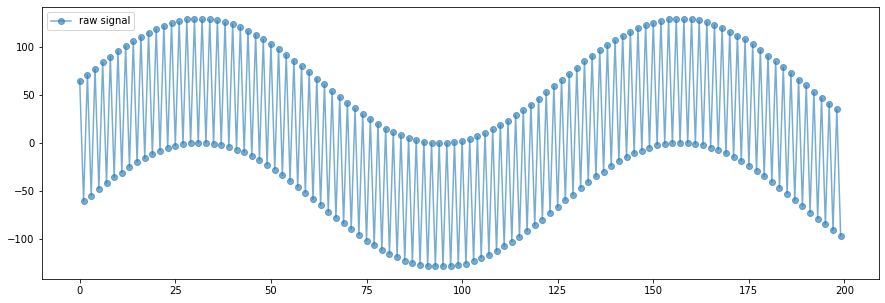

In [53]:
t = np.arange(len(input_sig)) # array for the x coordinate, just for displaying

plt.figure(figsize=(15, 5))

plt.plot(t, input_sig, '-o',alpha=.6,label='raw signal')
plt.legend(loc="upper left")

In [12]:
# After being computed on the actual FPGA

In [37]:
# we save the result obtained using the testbench in a array named tb
fpga = [0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,8,15,16,16,16,16,16,16,16,16,17,17,18,18,18,18,18,18,18,17,10,3,2,2,2,2,2,2,2,2,-7,-15,-15,-15,-15,-15,-15,-15,-15,-16,-17,-19,-19,-19,-19,-19,-19,-19,-19,-19,-13,-7,-6,-6,-6,-6,-6,-6,-6,-5,3,12,13,13,13,13,13,13,13,13,16,19,19,19,19,19,19,19,19,19,13,8,8,8,8,8,8,8,8,7,-2,-10,-11,-11,-11,-11,-11,-11,-11,-12,-16,-20,-20,-20,-20,-20,-20,-20,-20,-20,-16,-11,-11,-11,-11,-11,-11,-11,-11,-10,-2,7,8,8,8,8,8,8,8,8,14,19,19,19,19,18,4,2,10,10,0,-9,-6,-5,-5,-5,-5,-5,-5,-5,-3,-5,-2,-7,-6,1,2,2,2,1,-4,-4,-3,-3,-3,-3,-3,-3,-3,-3,-1,0,1,1,1,1,1,1,1,1,8,0,-1,-1,-1]
for i in range(len(fpga)):
    fpga[i] = 4*fpga[i]

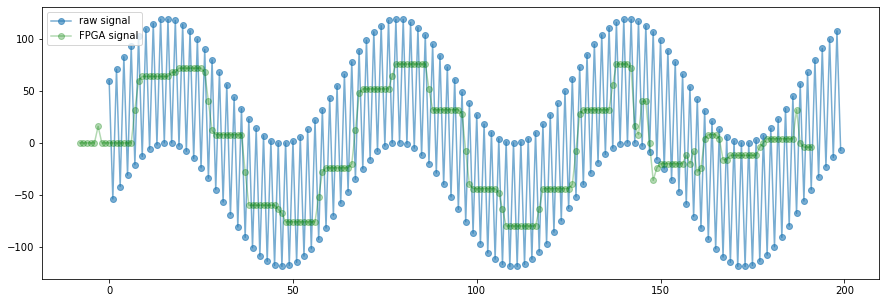

In [38]:
plt.figure(figsize=(15, 5))

t = np.arange(len(input_sig))
plt.plot(t, input_sig, '-o',alpha=.6,label='raw signal')
t = np.arange(len(fpga))
plt.plot(t-8, fpga, '-o', color='g',alpha=.3,label='FPGA signal')
#plt.title("")
#plt.xlim(0,130) #just for the latex report
plt.legend(loc="upper left")